In [1]:
import re
import swifter
import numpy as np
import pandas as pd
from typing import List, Union
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dropout, Dense, GlobalAveragePooling1D, GRU, Bidirectional

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/User/Desktop/FINAL-THESIS/en_dataset_aug.csv')

df.head()

,tweet,abusive,hateful,offensive,disrespectful,fearful,normal,tweet_cleaned
0,call sis im boy girl still faggot shut,0,0,1,0,0,0,call sis boy girl still faggot shut
1,@user @user legit nilas retarded idk,0,0,1,1,0,0,legit nilas retarded idk
2,said retard @url,1,1,1,0,1,0,said retard
3,america another 8 years obama's ideology via h...,1,1,0,1,1,1,america another years obama ideology via hilla...
4,@user don... fucking made cry twat.,0,0,1,0,0,0,don fucking made cry twat


In [3]:
output_labels = ["abusive", "hateful", "offensive", "disrespectful", "fearful", "normal"]
n_labels = len(output_labels)

# Discard Empty Tweets if There Any.
empty_tweet_filter = df["tweet"] != ""
df = df[empty_tweet_filter]
df = df.dropna()

In [4]:
df['abusive'] = df['abusive'].astype(np.int)
df['hateful'] = df['hateful'].astype(np.int)
df['offensive'] = df['offensive'].astype(np.int)
df['disrespectful'] = df['disrespectful'].astype(np.int)
df['fearful'] = df['fearful'].astype(np.int)
df['normal'] = df['normal'].astype(np.int)


toxic_comments_labels = df[output_labels]

df['one_hot_labels'] = list(df[output_labels].values)

Value Counts of Categories:

abusive: 1232
hateful: 1811
offensive: 4572
disrespectful: 1434
fearful: 1085
normal: 1826


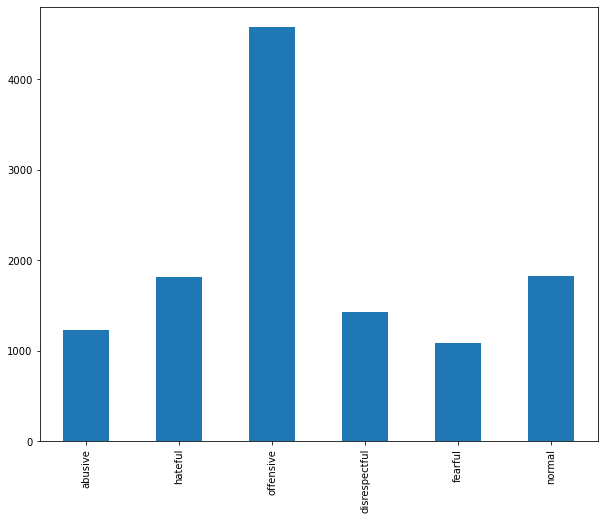

In [5]:
print("Value Counts of Categories:\n")
for category in toxic_comments_labels.columns[0:6]:
    print(f"{category}: {toxic_comments_labels[category].sum()}")

# Plot the Distribution of Target Labels in the Dataset
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
toxic_comments_labels.sum(axis=0).plot.bar()
plt.show()

In [6]:
idx2label = dict(zip(range(15),output_labels))
labels = list(df.one_hot_labels.values)
idx2label

{0: 'abusive',
 1: 'hateful',
 2: 'offensive',
 3: 'disrespectful',
 4: 'fearful',
 5: 'normal'}

In [7]:
# Identifying indices of 'one_hot_labels' entries that only occur once - we will then ensure to put these rows in the training set.
df = df.reset_index()
label_counts = df.one_hot_labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [3551, 3323, 2421]


In [8]:
one_freq_df = df.iloc[one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

df = df.drop(df.index[one_freq_idxs])

In [9]:
df_train, df_val = train_test_split(df, test_size=0.15, random_state=2021)
df_test = df_val[:100]
df_val = df_val[100:]

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)


#df_train = pd.concat([df_train, one_freq_df])

(5608, 10)
(100, 10)
(890, 10)


In [10]:
train_sentences = df_train["tweet_cleaned"].values
test_sentences = df_test["tweet_cleaned"].values
val_sentences = df_val["tweet_cleaned"].values

train_y = df_train[output_labels].values
test_y = df_test[output_labels].values
val_y = df_val[output_labels].values

In [11]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", 
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 1024].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 1024].

x = GlobalAveragePooling1D()(sequence_output)
x = Dropout(0.3)(x)
output = Dense(n_labels, activation='sigmoid', name='outputs')(x)

model = Model(inputs=text_input, outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4, decay=1e-6), 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc',multi_label=True, thresholds=[0, 0.5]),
                       tf.keras.metrics.TruePositives(name='TP'),
                       tf.keras.metrics.TrueNegatives(name='TN'),
                       tf.keras.metrics.FalsePositives(name='FP'),
                       tf.keras.metrics.FalseNegatives(name='FN')])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           input_1[0][0]                    
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'encoder_outputs':  109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [12]:
checkpointer = ModelCheckpoint(filepath="C:/Users/User/Desktop/FINAL-THESIS/model_weights/NN_weights.hdf5", 
                               verbose=1, save_best_only=True)

history = model.fit(train_sentences, train_y, epochs=15, 
                    batch_size=32, callbacks=[checkpointer],
                    validation_data=(val_sentences, val_y))

Epoch 1/15
176/176 [==============================] - 4131s 23s/step - loss: 0.5449 - accuracy: 0.5000 - precision: 0.6718 - recall: 0.3976 - auc: 0.5112 - TP: 4071.0000 - TN: 21420.0000 - FP: 1989.0000 - FN: 6168.0000 - val_loss: 0.5106 - val_accuracy: 0.5056 - val_precision: 0.6110 - val_recall: 0.5492 - val_auc: 0.5758 - val_TP: 842.0000 - val_TN: 3271.0000 - val_FP: 536.0000 - val_FN: 691.0000

Epoch 00001: val_loss improved from inf to 0.51061, saving model to C:/Users/User/Desktop/FINAL-THESIS/model_weights\NN_weights.hdf5
Epoch 2/15
176/176 [==============================] - 3798s 22s/step - loss: 0.5026 - accuracy: 0.5077 - precision: 0.6866 - recall: 0.4930 - auc: 0.5803 - TP: 5048.0000 - TN: 21105.0000 - FP: 2304.0000 - FN: 5191.0000 - val_loss: 0.4876 - val_accuracy: 0.5303 - val_precision: 0.6994 - val_recall: 0.4827 - val_auc: 0.5579 - val_TP: 740.0000 - val_TN: 3489.0000 - val_FP: 318.0000 - val_FN: 793.0000

Epoch 00002: val_loss improved from 0.51061 to 0.48764, saving 

KeyboardInterrupt: 

In [13]:
#Metrics Plots
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [14]:
model.load_weights(filepath='C:/Users/User/Desktop/FINAL-THESIS/NN_weights.hdf5')

In [28]:
results = model.evaluate(test_sentences, test_y, batch_size=64)

2/2 [==============================] - 22s 9s/step - loss: 0.2722 - accuracy: 0.6100 - precision: 0.8509 - recall: 0.7740 - auc: 0.7878 - TP: 137.0000 - TN: 399.0000 - FP: 24.0000 - FN: 40.0000


In [29]:
#Initializing Metrics
F1_score = 2 * (results[2] * results[3])/(results[2] + results[3])
AUC=results[4]
TP=results[5]
TN=results[6]
FP=results[7]
FN=results[8]


#Printing Metrics Results
print("F1 SCORE: ", F1_score)
print("AUC SCORE: ", AUC)
print("True Positives: ", TP)
print("True Negatives: ", TN)
print("False Positives: ", FP)
print("False Negatives: ", FN)

F1 SCORE:  0.8106509077795655
AUC SCORE:  0.7878112196922302
True Positives:  137.0
True Negatives:  399.0
False Positives:  24.0
False Negatives:  40.0


In [30]:
y_pred = model.predict(test_sentences)
y_pred = np.where(y_pred > 0.5, 1, 0)

y_true = test_y

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=output_labels))

               precision    recall  f1-score   support

      abusive       0.77      0.59      0.67        17
      hateful       0.83      0.43      0.57        23
    offensive       0.84      0.96      0.90        76
disrespectful       0.93      0.78      0.85        18
      fearful       0.91      0.71      0.80        14
       normal       0.87      0.69      0.77        29

    micro avg       0.85      0.77      0.81       177
    macro avg       0.86      0.69      0.76       177
 weighted avg       0.85      0.77      0.80       177
  samples avg       0.81      0.76      0.77       177



In [27]:
for i, sent in enumerate(test_sentences):
    print("tweet: ", sent)
    true, pred = y_true[i], y_pred[i]
    print("pred labels: ", [idx2label[idx] for idx in np.where(pred == 1)[0]])
    print("true labels: ", [idx2label[idx] for idx in np.where(true == 1)[0]])
    print()

tweet:  holy shit lake charles la attractive women call spic texting fr
pred labels:  ['offensive']
true labels:  ['offensive']

tweet:  ingenious portmanteau liberal retard marthann george washington
pred labels:  ['offensive']
true labels:  ['offensive', 'normal']

tweet:  Play Comp Game Actual Buns Cunt Pony Riot Shields got ta fucking go
pred labels:  ['abusive', 'hateful', 'disrespectful', 'fearful', 'normal']
true labels:  ['abusive', 'hateful', 'disrespectful', 'fearful', 'normal']

tweet:  radical leftist contributor calls terrorist sympathizer he is sympathize
pred labels:  ['normal']
true labels:  ['normal']

tweet:  Worse still, social fascist comes calling
pred labels:  ['offensive', 'disrespectful']
true labels:  ['offensive', 'disrespectful']

tweet:  twat probably right lufc
pred labels:  ['offensive']
true labels:  ['offensive']

tweet:  lost raghead
pred labels:  ['normal']
true labels:  ['normal']

tweet:  am fucking screaming sis actually changed name nigger quarter
